# 实验二

任务：
预测任务是确定一个人的年收入是否超过 50K

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## 1. 数据处理
### 1.0 导入数据

In [2]:
# 导入数据
df = pd.read_csv('./adult.data',
                 names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
                        'native-country', 'income'])

# fnlwgt是编号
df.drop('fnlwgt', axis=1, inplace=True)

df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   education-num   32561 non-null  int64 
 4   marital-status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  income          32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


### 1.1 缺失值处理

In [135]:
# 去除所有列中字符串两侧的空格
df_ = df.copy()

for col in df_.columns:
    if df_[col].dtype == object:  # 只处理字符串列
        df_[col] = df_[col].str.strip()

# 将 "?" 替换为 NaN
df_.replace("?", np.nan, inplace=True)

# 删除缺失值样本
df_.dropna(axis=0, inplace=True)

# 打印数据框信息
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   education       30162 non-null  object
 3   education-num   30162 non-null  int64 
 4   marital-status  30162 non-null  object
 5   occupation      30162 non-null  object
 6   relationship    30162 non-null  object
 7   race            30162 non-null  object
 8   sex             30162 non-null  object
 9   capital-gain    30162 non-null  int64 
 10  capital-loss    30162 non-null  int64 
 11  hours-per-week  30162 non-null  int64 
 12  native-country  30162 non-null  object
 13  income          30162 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


## 2. 逻辑回归求解

### 2.1 数据归一化（方便梯度下降）

In [117]:
def normalize(data):
    for col in data.columns:
        if np.issubdtype(data[col].values.dtype, np.number):  # Check if the column contains numerical values
            sigma = np.std(data[col], axis=0)
            mu = np.mean(data[col], axis=0)
            data[col] = (data[col] - mu) / sigma

    return data


# 归一化
norm_df = normalize(df_)
norm_df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.042796,State-gov,Bachelors,1.128918,Never-married,Adm-clerical,Not-in-family,White,Male,0.146092,-0.218586,-0.077734,United-States,<=50K
1,0.880288,Self-emp-not-inc,Bachelors,1.128918,Married-civ-spouse,Exec-managerial,Husband,White,Male,-0.147445,-0.218586,-2.331531,United-States,<=50K
2,-0.033340,Private,HS-grad,-0.439738,Divorced,Handlers-cleaners,Not-in-family,White,Male,-0.147445,-0.218586,-0.077734,United-States,<=50K
3,1.108695,Private,11th,-1.224066,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,-0.147445,-0.218586,-0.077734,United-States,<=50K
4,-0.794697,Private,Bachelors,1.128918,Married-civ-spouse,Prof-specialty,Wife,Black,Female,-0.147445,-0.218586,-0.077734,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.870832,Private,Assoc-acdm,0.736754,Married-civ-spouse,Tech-support,Wife,White,Female,-0.147445,-0.218586,-0.244682,United-States,<=50K
32557,0.118931,Private,HS-grad,-0.439738,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,-0.147445,-0.218586,-0.077734,United-States,>50K
32558,1.489374,Private,HS-grad,-0.439738,Widowed,Adm-clerical,Unmarried,White,Female,-0.147445,-0.218586,-0.077734,United-States,<=50K
32559,-1.251511,Private,HS-grad,-0.439738,Never-married,Adm-clerical,Own-child,White,Male,-0.147445,-0.218586,-1.747213,United-States,<=50K


### 2.2 编码

In [118]:
encode_df = norm_df.copy()  # 存放编码后的数据
encode_list = {}  # 编码器，方便后续的反编码

for col in encode_df.columns:
    if encode_df[col].dtype == object:  # 字符型数据
        encode_list[col] = LabelEncoder()
        encode_df[col] = encode_list[col].fit_transform(encode_df[col])

encode_df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.042796,5,9,1.128918,4,0,1,4,1,0.146092,-0.218586,-0.077734,38,0
1,0.880288,4,9,1.128918,2,3,0,4,1,-0.147445,-0.218586,-2.331531,38,0
2,-0.033340,2,11,-0.439738,0,5,1,4,1,-0.147445,-0.218586,-0.077734,38,0
3,1.108695,2,1,-1.224066,2,5,0,2,1,-0.147445,-0.218586,-0.077734,38,0
4,-0.794697,2,9,1.128918,2,9,5,2,0,-0.147445,-0.218586,-0.077734,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.870832,2,7,0.736754,2,12,5,4,0,-0.147445,-0.218586,-0.244682,38,0
32557,0.118931,2,11,-0.439738,2,6,0,4,1,-0.147445,-0.218586,-0.077734,38,1
32558,1.489374,2,11,-0.439738,6,0,4,4,0,-0.147445,-0.218586,-0.077734,38,0
32559,-1.251511,2,11,-0.439738,4,0,3,4,1,-0.147445,-0.218586,-1.747213,38,0


### 2.3 划分数据集

In [119]:
# 拆分数据集
feature = encode_df.iloc[:, 0:-1]
label = encode_df.iloc[:, -1]

Xtrain, Xtest, Ytrain, Ytest = train_test_split(feature, label, test_size=0.1, random_state=1314)

X = np.array(Xtrain).reshape(-1,13)
y = np.array(Ytrain).reshape(-1, 1)
Xtest = Xtest.values
Ytest = Ytest.values

### 2.4 求解

In [120]:
# 编写一个类将逻辑回归封装起来
class LogisticRegression:
    def __init__(self):
        self.theta = None
        self.epochs_loss = []
        self.fit_epoch = -1

    # Sigmoid函数
    def _sigmoid(self, X):
        return 1 / (1 + np.exp(-(X @ self.theta)))

    # 损失函数
    def _loss(self, y, y_pred):
        m = len(y)
        epsilon = 1e-5
        # 计算损失
        J = - (1 / m) * (np.sum(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon)))
        return J

    # 训练函数
    def fit(self, X, y, lr=0.01, epochs=1500):
        m, n = X.shape
        self.fit_epoch = epochs

        # 初始化参数为标准正态分布
        self.theta = np.random.randn(n, 1)

        for epoch in range(epochs):
            # 计算激活值
            h = self._sigmoid(X)
            # 计算梯度
            gradient = X.T @ (h - y) / m
            # 计算损失并保存
            J = self._loss(y, h)
            self.epochs_loss.append(J)
            # 更新参数
            self.theta -= lr * gradient

    # 预测函数
    def predict(self, X):
        # 异常处理
        if self.theta is None:
            raise ValueError("请先调用fit进行训练！")
        # 进行预测
        h = self._sigmoid(X)
        return (h >= 0.5).astype(int)

    # 绘图函数:绘制损失函数梯度下降曲线
    def drawloss(self):
        sns.lineplot(x=np.arange(self.fit_epoch), y=self.epochs_loss, label='Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Gradient Descent Loss Curve')
        plt.savefig("1.png",dpi=800)
        plt.show()

    # 获取训练后的theta
    def report(self):
        # 创建 DataFrame 以查看结果
        result = pd.DataFrame({"ColumnName": list(feature.columns), "Theta": self.theta.flatten()})
        return result

    # 计算准确率
    def score(self, label_true, label_predict):
        # 确保label_true和label_predict的长度相同
        if len(label_true) != len(label_predict):
            raise ValueError("label_true和label_predict的长度不一致")

        # 计算准确率并返回
        accuracy = sum(label_true.reshape(-1, 1) == label_predict.reshape(-1, 1)) / len(label_predict)
        return accuracy

In [121]:
# 实例化
log_reg = LogisticRegression()
# 训练模型
log_reg.fit(X, y)
# 查看训练报告
log_reg.report()

,ColumnName,Theta
0,age,0.697540
1,workclass,-0.243477
2,education,0.031554
3,education-num,1.374568
4,marital-status,-0.036948
5,occupation,-0.009319
6,relationship,-0.684311
7,race,-0.385657
8,sex,0.087865
9,capital-gain,-0.139866


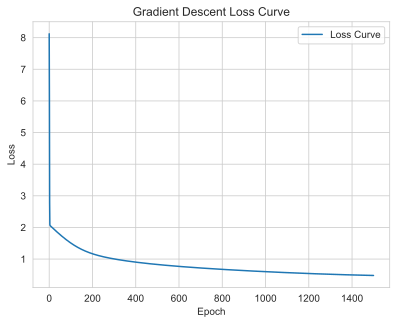

In [122]:
# 绘图
log_reg.drawloss()

In [123]:
# 进行预测
print(f"准确率：{log_reg.score(Ytest, log_reg.predict(Xtest))}")

准确率：[0.7978124]


## 3. 贝叶斯回归求解


### 3.0 查看分布

C:\Users\DREAM\AppData\Local\Temp\ipykernel_27412\285849271.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 2].set_xticklabels(axes[0, 2].get_xticklabels(), rotation=90)


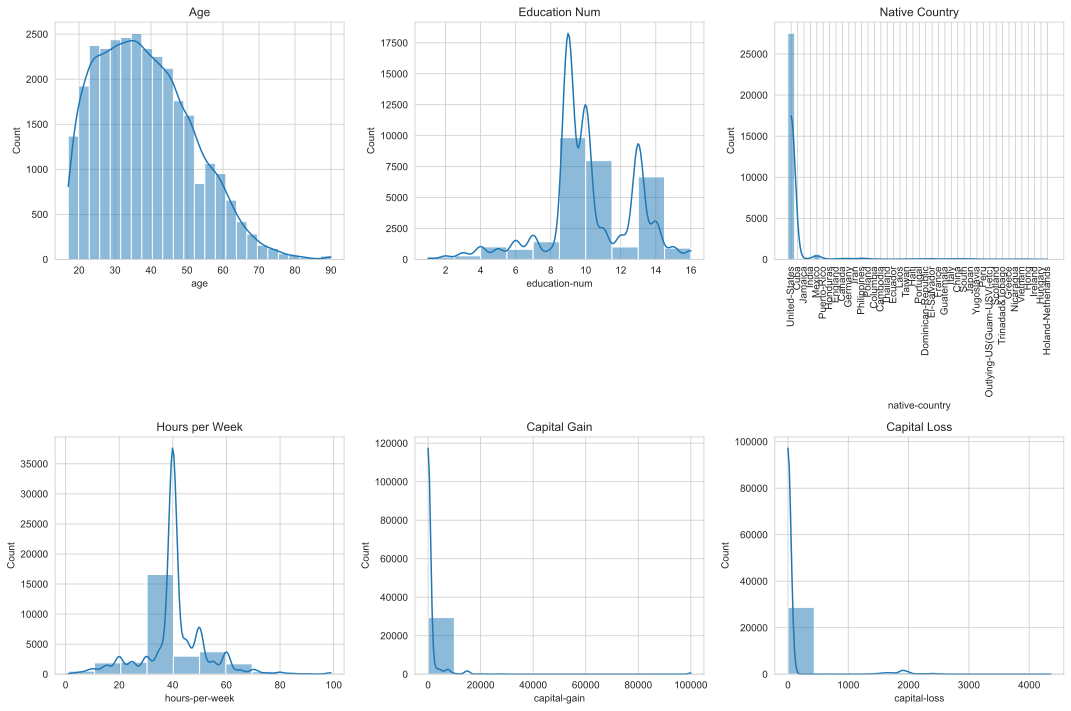

In [136]:
# 创建一个 2x3 的子图布局
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 绘制第一个直方图：'age'
sns.histplot(data=df_['age'], kde=True, bins=25, ax=axes[0, 0])
axes[0, 0].set_title('Age')

# 绘制第二个直方图：'education-num'
sns.histplot(data=df_['education-num'], kde=True, bins=10, ax=axes[0, 1])
axes[0, 1].set_title('Education Num')

# 绘制第三个直方图：'native-country'
sns.histplot(data=df_['native-country'], kde=True, bins=10, ax=axes[0, 2])
axes[0, 2].set_title('Native Country')
axes[0, 2].set_xticklabels(axes[0, 2].get_xticklabels(), rotation=90)

# 绘制第四个直方图：'hours-per-week'
sns.histplot(data=df_['hours-per-week'], kde=True, bins=10, ax=axes[1, 0])
axes[1, 0].set_title('Hours per Week')

# 绘制第五个直方图：'capital-gain'
sns.histplot(data=df_['capital-gain'], kde=True, bins=10, ax=axes[1, 1])
axes[1, 1].set_title('Capital Gain')

# 绘制第六个直方图：'capital-loss'
sns.histplot(data=df_['capital-loss'], kde=True, bins=10, ax=axes[1, 2])
axes[1, 2].set_title('Capital Loss')

# 调整子图之间的间距
plt.tight_layout()
plt.savefig("1.png",dpi=800)
plt.show()

### 3.1 连续型变量离散化

In [125]:
encode_df_ = df_.copy()

# 划分'age'属性为'0-25', '25-45', '45-65', '65-100'四类
encode_df_['age'] = pd.cut(encode_df_['age'], bins=[-1, 25, 45, 65, 100], labels=['0-25', '25-45', '45-65', '65-100'],
                           include_lowest=True)

# 划分'education-num'属性为'<5', '5-10', '>10'三类
encode_df_['education-num'] = pd.cut(encode_df_['education-num'], bins=[-1, 5, 10, float('inf')],
                                     labels=['<5', '5-10', '>10'], include_lowest=True)

# 划分'native-country'属性为'USA'和'not USA'两类
encode_df_['native-country'] = encode_df_['native-country'].apply(lambda x: 1 if x == 'United-States' else 0)

# 划分'hours-per-week'属性为'<40', '=40', '>40'三类
encode_df_['hours-per-week'] = pd.cut(encode_df_['hours-per-week'], bins=[-1, 40, 40.1, float('inf')],
                                      labels=['<40', '=40', '>40'], include_lowest=True)

# 划分'capital-gain'属性为'=0'和'>0'两类
encode_df_['capital-gain'] = pd.cut(encode_df_['capital-gain'], bins=[float('-inf'), 0, float('inf')],
                                    labels=['=0', '>0'], include_lowest=True)

# 划分'capital-loss'属性为'>0'和'=0'两类
encode_df_['capital-loss'] = pd.cut(encode_df_['capital-loss'], bins=[float('-inf'), 0, float('inf')],
                                    labels=['>0', '=0'], include_lowest=True)

encode_df_

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0-25,State-gov,Bachelors,<5,Never-married,Adm-clerical,Not-in-family,White,Male,>0,>0,<40,1,<=50K
1,0-25,Self-emp-not-inc,Bachelors,<5,Married-civ-spouse,Exec-managerial,Husband,White,Male,=0,>0,NaN,1,<=50K
2,0-25,Private,HS-grad,<5,Divorced,Handlers-cleaners,Not-in-family,White,Male,=0,>0,<40,1,<=50K
3,0-25,Private,11th,NaN,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,=0,>0,<40,1,<=50K
4,0-25,Private,Bachelors,<5,Married-civ-spouse,Prof-specialty,Wife,Black,Female,=0,>0,<40,0,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0-25,Private,Assoc-acdm,<5,Married-civ-spouse,Tech-support,Wife,White,Female,=0,>0,<40,1,<=50K
32557,0-25,Private,HS-grad,<5,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,=0,>0,<40,1,>50K
32558,0-25,Private,HS-grad,<5,Widowed,Adm-clerical,Unmarried,White,Female,=0,>0,<40,1,<=50K
32559,NaN,Private,HS-grad,<5,Never-married,Adm-clerical,Own-child,White,Male,=0,>0,NaN,1,<=50K


### 3.2 编码

In [126]:
 # 使用LabelEncoder对分类变量进行编码
encode_list_ = {}
for col in encode_df_.columns:
    encode_list_[col] = LabelEncoder()
    encode_df_[col] = encode_list_[col].fit_transform(encode_df_[col])

encode_df_

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0,5,9,0,4,0,1,4,1,1,1,0,1,0
1,0,4,9,0,2,3,0,4,1,0,1,1,1,0
2,0,2,11,0,0,5,1,4,1,0,1,0,1,0
3,0,2,1,1,2,5,0,2,1,0,1,0,1,0
4,0,2,9,0,2,9,5,2,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,2,7,0,2,12,5,4,0,0,1,0,1,0
32557,0,2,11,0,2,6,0,4,1,0,1,0,1,1
32558,0,2,11,0,6,0,4,4,0,0,1,0,1,0
32559,1,2,11,0,4,0,3,4,1,0,1,1,1,0


### 3.3 划分数据集

In [127]:
# 拆分数据集
feature_ = encode_df_.iloc[:, 0:-1]
label_ = encode_df_.iloc[:, -1]

Xtrain_, Xtest_, Ytrain_, Ytest_ = train_test_split(feature_, label_, test_size=0.2, random_state=1314)

X = Xtrain_
y = Ytrain_

### 3.4 求解

In [128]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_probs = {}  # 存储 P(Y)
        self.feature_probs = {}  # 存储 P(X|Y)
        self.epsilon = 1e-10  # 防止log(0)

    # 训练函数
    def fit(self, X, y):
        # 获取样本数量和特征数量
        num_samples, num_features = X.shape

        # 获取所有唯一的类别（目标变量的不同取值）
        self.classes = np.unique(y)

        # 计算主循环，遍历每个类别
        for c in self.classes:
            # 计算 P(Y)
            self.class_probs[c] = np.sum(y == c) / num_samples

            # 计算对于每个特征 P(X_i|Y) 
            self.feature_probs[c] = []
            # 遍历每个特征列
            for feature_name in X.columns:
                # 获取当前特征列的唯一取值
                unique_values = np.unique(X[feature_name])

                # 存储当前特征在给定类别下的概率
                feature_prob = {}
                # 遍历当前特征的所有可能取值
                for value in unique_values:
                    # Laplace平滑以处理未出现的值，计算 P(X_i = value | Y = c)
                    feature_prob[value] = (np.sum((X[feature_name] == value) & (y == c)) + 1) / (
                            np.sum(y == c) + len(unique_values))
                # 将当前特征在给定类别下的概率存储起来
                self.feature_probs[c].append(feature_prob)

    # 预测函数
    def predict(self, X):
        # 初始化一个列表来存储预测结果
        predictions = []

        # 遍历样本数据集中的每一行
        for sample in X.values:
            # 初始化最大概率和预测类别
            max_prob = -1
            predicted_class = None

            # 遍历每个类别，计算 P(Y|X)
            for c in self.classes:
                # 计算 P(Y|X) = P(Y) * P(X1|Y) * P(X2|Y) * ...
                prob = np.log(self.class_probs[c])

                # 遍历当前样本的每个特征值
                for feature_index, value in enumerate(sample):
                    # 使用取对数的方式累加特征条件概率，避免数值下溢
                    prob += np.log(self.feature_probs[c][feature_index].get(value, self.epsilon))  # 避免 log(0) 添加一个小值

                # 选择概率最高的类别
                if prob > max_prob or predicted_class is None:
                    max_prob = prob
                    predicted_class = c

            # 将预测的类别添加到结果列表中
            predictions.append(predicted_class)

        # 返回最终的预测结果
        return predictions

    # 获取训练结果
    def report(self):
        # P(Y)
        print("P(Y): ")
        for c, prob in zip(self.classes, self.class_probs.values()):
            print(f"Class {c}: {prob}")

        print(f"--------------------------------------------------------\n")

        # P(X|Y)
        print("\nP(X|Y): ")
        for c, feature_probs_list in self.feature_probs.items():
            print(f"\nClass {c}:")
            for feature_name, feature_prob_dict in zip(encode_df_.columns, feature_probs_list):
                print(f"\nFeature {feature_name}:")
                for value, prob in feature_prob_dict.items():
                    print(f"Value {value}: {prob}")

    # 计算准确率
    def score(self, label_true, label_predict):
        # 确保label_true和label_predict的长度相同
        if len(label_true) != len(label_predict):
            raise ValueError("label_true和label_predict的长度不一致")

        # 计算准确率并返回
        accuracy = sum(label_true == label_predict) / len(label_predict)
        return accuracy

In [129]:
# 实例化
nb = NaiveBayesClassifier()
# 训练
nb.fit(Xtrain_, Ytrain_)
# 查看模型参数
nb.report()

P(Y): 
Class 0: 0.7517924489203862
Class 1: 0.24820755107961373
--------------------------------------------------------


P(X|Y): 

Class 0:

Feature age:
Value 0: 0.7562010803660015
Value 1: 0.24379891963399847

Feature workclass:
Value 0: 0.025513859040061718
Value 1: 0.06342646167410591
Value 2: 0.7678955199206481
Value 3: 0.020554361602468728
Value 4: 0.07995811979941587
Value 5: 0.04199041163828732
Value 6: 0.0006612663250123987

Feature education:
Value 0: 0.03387309980171844
Value 1: 0.04406256884776383
Value 2: 0.015587133729896454
Value 3: 0.005948446794448116
Value 4: 0.012502753910552986
Value 5: 0.022857457589777485
Value 6: 0.019112139237717558
Value 7: 0.03315708305794228
Value 8: 0.04279576999339062
Value 9: 0.1301498127340824
Value 10: 0.0040757876184181535
Value 11: 0.3624697069839172
Value 12: 0.03018285966071822
Value 13: 0.0018726591760299626
Value 14: 0.005783212161269002
Value 15: 0.23556950870235735

Feature education-num:
Value 0: 0.8599933855142763
Value 1: 0.

In [130]:
# 计算准确率
print(f"准确率: {nb.score(Ytest_, nb.predict(Xtest_))}")

准确率: 0.7903199071771921
